# Compute the Optical Flow to determine the direction of the vehicles

Before running the code make sure to have all the videos uploaded in the google collab environment by uploading the videos.zip file from the github repository.


In [1]:
!unzip videos.zip
!unzip new_videos.zip
!unzip videos_lane_change.zip

Archive:  videos.zip
replace videos/PXL_20210822_180954405.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: None
Archive:  new_videos.zip
replace new_videos/road_static_view.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: None
Archive:  videos_lane_change.zip
replace videos_lane_change/lane_change_test.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


### Auxiliary functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import filters
from scipy.stats import mode
import cv2
from google.colab.patches import cv2_imshow # because cv2.imshow crashes

# Function to display images
def display_image(img, title='', size=None):
    plt.gray()
    h = plt.imshow(img, interpolation='none')
    if size:
        dpi = h.figure.get_dpi()/size
        h.figure.set_figwidth(img.shape[1] / dpi)
        h.figure.set_figheight(img.shape[0] / dpi)
        h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
        h.axes.set_position([0, 0, 1, 1])
        h.axes.set_xlim(-1, img.shape[1])
        h.axes.set_ylim(img.shape[0], -1)
    plt.grid(False)
    plt.title(title)  
    plt.show()

def resize_frame(frame):
    # Resize of frame while keeping ratio
    if frame.shape[1] > 800:
        scale_percent = 20 
        width = int(frame.shape[1] * scale_percent / 100)
        height = int(frame.shape[0] * scale_percent / 100)
        dim = (width, height)
        ## Function to resize image
        resized_frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    else:
        resized_frame = frame
    return resized_frame

# Function to preprocess images before using them
def preprocessing(frame):
    
    resized_frame = resize_frame(frame)
    
    # Convert to graylevel
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    
    return gray_frame

def check_for_duplicates(list_elem):
    new_list = []
    for elem in list_elem:
        duplicate = False
        for new_elem in new_list:
            dist = np.sqrt( (new_elem[0][0] - elem[0][0])**2 + (new_elem[0][1] - elem[0][1])**2 )
            if dist < 15:  # Consider two keypoints the same when they are closer than 15 pixels appart
                duplicate = True
                break
        if not duplicate:
            new_list.append(elem)
    return np.array(new_list)

def put_inside_frame_dim(shape, coord):
    height, width = shape
    x,y = coord
    x = max(min(width-1, x), 0)
    y = max(min(height-1, y), 0)
    return (x,y)

## Static video


### Obtain background

In [3]:
def obtain_background(file_name):
  cap = cv2.VideoCapture(file_name)
  # read the video frame
  ret,frame = cap.read() 

  frame_gray = preprocessing(frame)

  # Define a 3D matrix to store the 100 images to generate the average
  width = frame_gray.shape[1]
  height = frame_gray.shape[0]
  all_frames = np.zeros((275,height,width))

  # Loop over frames from the video stream and accumulate all frames in a single variable                                                                                                    
  for i in range(275):
      if i%10 == 0:
        print ('Processing frame {}'.format (i))
      
      # Store the frame in the matrix
      all_frames[i,:,:] = frame_gray

      ret,frame = cap.read()
      if ret is False: # If something failed ...
          break
      frame_gray = preprocessing(frame)

  # Average the 100 frames
  background = np.average(all_frames,axis=0)

  # Convert to uint8 data type
  background = background.astype(np.uint8)

  return background

In [4]:
background = obtain_background('new_videos/road_static_view.mp4')

Processing frame 0
Processing frame 10
Processing frame 20
Processing frame 30
Processing frame 40
Processing frame 50
Processing frame 60
Processing frame 70
Processing frame 80
Processing frame 90
Processing frame 100
Processing frame 110
Processing frame 120
Processing frame 130
Processing frame 140
Processing frame 150
Processing frame 160
Processing frame 170
Processing frame 180
Processing frame 190
Processing frame 200
Processing frame 210
Processing frame 220
Processing frame 230
Processing frame 240
Processing frame 250
Processing frame 260
Processing frame 270


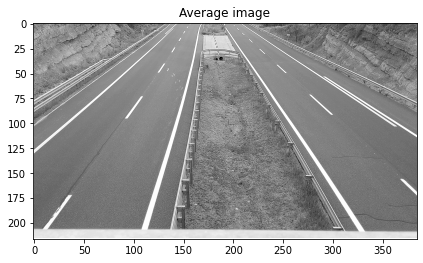

In [5]:
display_image(background, 'Average image', size=1)

### Detecting moving objects

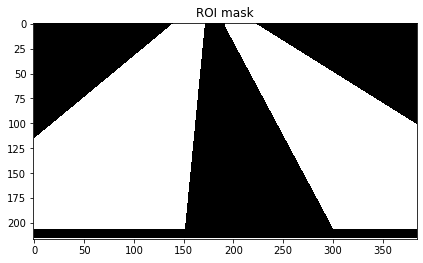

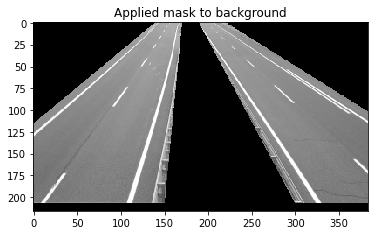

In [6]:
# Load the image defining the mask
# Creation of mask
width = background.shape[1]
height = background.shape[0]
offset = 10
height -= offset
trapezoide1 = np.array([[(-110, height), (140,0), (170, 0), (150, height),]], np.int32)
trapezoide2 = np.array([[(300, height), (190,0), (220, 0), (550, height),]], np.int32)
roi_mask = np.zeros_like(background)
cv2.fillPoly(roi_mask, trapezoide1, 255)
cv2.fillPoly(roi_mask, trapezoide2, 255)

## Apply mask
background_masked = cv2.bitwise_and(background, roi_mask)

display_image(roi_mask, 'ROI mask', size=1)
display_image(background_masked, 'Applied mask to background')

In [7]:
import time

cap = cv2.VideoCapture("new_videos/road_static_view.mp4")

# read the video frame
success, frame = cap.read()
frame_gray = preprocessing(frame)

# Creating the kernels
kernel1 = np.ones((2,3), np.uint8)
kernel2 = np.ones((4,4), np.uint8)

# Config output video
## mp4
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("new_videos/road_static_movement.mp4", fourcc, 30, (frame_gray.shape[1], frame_gray.shape[0]), False)

success, frame = cap.read()

while success:
    frame_gray = preprocessing(frame)
    
    moving_obj_frame = cv2.absdiff(background, frame_gray)
    moving_obj_frame = cv2.bitwise_and(moving_obj_frame, roi_mask)
    th, moving_obj_frame = cv2.threshold(moving_obj_frame, 20, 255, cv2.THRESH_BINARY)
    img_erosion = cv2.erode(moving_obj_frame, kernel1, iterations=1)
    img_dilation = cv2.dilate(moving_obj_frame, kernel2, iterations=1)
    
    # Display frame
    ## Google Collab display
    #cv2_imshow(frame_gray)
    #cv2_imshow(moving_obj_frame)
    #cv2_imshow(img_erosion)
    #cv2_imshow(img_dilation)
    ## Jupyter notebook display
    #cv2_imshow('Movement detection', moving_obj_frame)
    #cv2_imshow('Erosion', img_erosion)
    #cv2_imshow('Dilation', img_dilation)
    #cv2_imshow('Traffic camera', frame_gray)
    #time.sleep(0.05)

    # Write the output frame to disk
    writer.write(img_dilation)
    
    # Capture the next frame in the video
    success, frame = cap.read()

cv2.destroyAllWindows()
writer.release()

### Optical flow

In [8]:
cap = cv2.VideoCapture('new_videos/road_static_view.mp4')
cap_mask = cv2.VideoCapture('new_videos/road_static_movement.mp4')

# Config output video
## mp4
vid_width  = int(cap_mask.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_height = int(cap_mask.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("new_videos/road_static_optical_flow.mp4", fourcc, 30, (vid_width, vid_height), True)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 3,
                       qualityLevel = 0.3,
                       minDistance = 10,
                       blockSize = 7)

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.3))

color = (10, 0, 255) # red

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = preprocessing(old_frame)

ret, old_mask_frame = cap_mask.read()
old_mask_frame_gray = preprocessing(old_mask_frame)

p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)

# Wait to obtain the first mask that has something to track before obtaining any keypoints
while not cv2.countNonZero(old_mask_frame_gray):
    ret, old_frame = cap.read()
    old_gray = preprocessing(old_frame)

    ret, old_mask_frame = cap_mask.read()
    old_mask_frame_gray = preprocessing(old_mask_frame)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    

# Create a mask image for drawing purposes
old_frame = resize_frame(old_frame)
mask = np.zeros_like(old_frame)
fade = np.ones_like(old_frame)*10

ret, frame = cap.read()
ret, mask_frame = cap_mask.read()

while(ret):

    frame_gray = preprocessing(frame)
    mask_frame_gray = preprocessing(mask_frame)
    frame = resize_frame(frame)
    
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_mask_frame_gray, mask_frame_gray, p0, None, **lk_params)
    
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]


    # Draw the tracks and remove keypoints that are static
    aux_good_new = np.array([])
    aux_good_old = np.array([])
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        dist = np.sqrt( (a - c)**2 + (b - d)**2)
        if dist > 0.01:
          mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color, 2)
          frame = cv2.circle(frame,(int(a),int(b)),5,color,-1)
          np.insert(aux_good_new, len(aux_good_new), new)
          np.insert(aux_good_old, len(aux_good_old), old)
    #print("Good " + str(good_new))
    #print("Aux " + str(aux_good_new))
    if len(aux_good_old) > 0:
      good_new = aux_good_new
      good_old = aux_good_old
    
    # Fading of lines
    mask = cv2.absdiff(mask, fade).astype('uint8')
    th, mask = cv2.threshold(mask, 15, 255, cv2.THRESH_TOZERO)
    
    # Join points and lines
    frame = resize_frame(frame)
    img = cv2.add(frame,mask)
    
    # Write the output frame to disk
    writer.write(img)
        
    # Detect new keypoints
    new_p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    if new_p0 is not None:
        p0 = np.concatenate([new_p0,p0])
        p0 = check_for_duplicates(p0)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_mask_frame_gray, mask_frame_gray, p0, None, **lk_params)
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
    
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    old_mask_frame_gray = mask_frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

    ret, frame = cap.read()
    ret, mask_frame = cap_mask.read()

writer.release()
cv2.destroyAllWindows()

### Direction of movement

In [9]:
cap = cv2.VideoCapture('new_videos/road_static_view.mp4')
cap_mask = cv2.VideoCapture('new_videos/road_static_movement.mp4')

# Config output video
## mp4
vid_width  = int(cap_mask.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_height = int(cap_mask.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("new_videos/road_static_direction.mp4", fourcc, 30, (vid_width, vid_height), True)


# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 2,
                       qualityLevel = 0.4,
                       minDistance = 10,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.3))

# Create some random colors
color = (10, 0, 255) # red

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = preprocessing(old_frame)

ret, old_mask_frame = cap_mask.read()
old_mask_frame_gray = preprocessing(old_mask_frame)

# Wait to obtain the first mask that has something to track before obtaining any keypoints
while not cv2.countNonZero(old_mask_frame_gray):
    ret, old_frame = cap.read()
    old_gray = preprocessing(old_frame)

    ret, old_mask_frame = cap_mask.read()
    old_mask_frame_gray = preprocessing(old_mask_frame)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    

# Create a mask image for drawing purposes
frame = resize_frame(frame)
mask = np.zeros_like(frame)
fade = np.ones_like(frame)*10

old_bgr = np.zeros_like(frame)
hsv = np.zeros_like(frame)
hsv[...,1] = 255

ret, frame = cap.read()
ret, mask_frame = cap_mask.read()

while(ret):

    frame_gray = preprocessing(frame)
    mask_frame_gray = preprocessing(mask_frame)
    frame = resize_frame(frame)
    
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # calculate direction of movement
    flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    # TODO: tune the parameters
    
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
        
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        # Obtaining points
        a,b = new.ravel()
        c,d = old.ravel()
        a = int(a)
        b = int(b)
        c = int(c)
        d = int(d)
        a,b = put_inside_frame_dim((frame.shape[0],frame.shape[1]), (a,b))
        c,d = put_inside_frame_dim((frame.shape[0],frame.shape[1]), (c,d))
        # Directional vector
        dir_vect = (a-c, b-d) 
        # Distance from the new point to the predicted one
        n = 2 
        prediction_point = (a+dir_vect[0]*n, b+dir_vect[1]*n)
        
        # Colors
        color = bgr[b,a].tolist() 
        old_color = old_bgr[d,c].tolist()
        base_lighting = 20
        new_color = [color[i]+old_color[i]+base_lighting for i in range(len(color))] 
        prediction_color = (0, 255, 0) # green
        if dir_vect[1] <= 0:
            prediction_color = (255,0, 0) # blue
            
        # Painting
        frame = cv2.line(frame, (a,b), prediction_point, prediction_color, 3)
        mask = cv2.line(mask, (a,b), (c,d), new_color, 2)
        frame = cv2.circle(frame, (a,b), 5, new_color, -1)
        
        
    mask = cv2.absdiff(mask, fade).astype('uint8')
    th, mask = cv2.threshold(mask, 15, 255, cv2.THRESH_TOZERO)
    
    img = cv2.add(frame,mask)
    
    # Write the output frame to disk
    writer.write(img)
        
    # Detect new keypoints - NOT WORKING
    new_p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    if new_p0 is not None:
        p0 = np.concatenate([new_p0,p0])
        p0 = check_for_duplicates(p0)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
    
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    old_mask_frame_gray = mask_frame_gray.copy()
    old_bgr = bgr
    p0 = good_new.reshape(-1,1,2)

    ret, frame = cap.read()
    ret, mask_frame = cap_mask.read()

writer.release()

## Test dummy video 



#### Obtain background

Processing frame 0
Processing frame 10
Processing frame 20
Processing frame 30
Processing frame 40
Processing frame 50
Processing frame 60
Processing frame 70
Processing frame 80
Processing frame 90
Processing frame 100
Processing frame 110
Processing frame 120
Processing frame 130
Processing frame 140
Processing frame 150
Processing frame 160
Processing frame 170
Processing frame 180
Processing frame 190
Processing frame 200
Processing frame 210
Processing frame 220
Processing frame 230
Processing frame 240
Processing frame 250
Processing frame 260
Processing frame 270


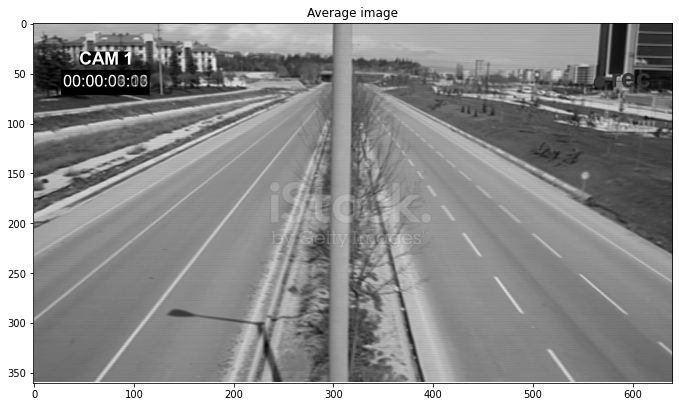

In [10]:
traffic_cam_background = obtain_background('videos/traffic_camera.mp4')
display_image(traffic_cam_background, 'Average image', size=1)

#### Detecting moving objects

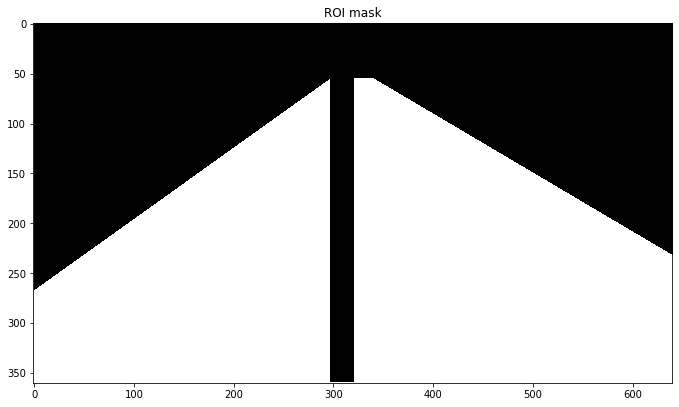

In [11]:
# Load the image defining the mask
roi_mask = cv2.imread('videos/traffic_camera_mask.png')
roi_mask = preprocessing(roi_mask*255)

display_image(roi_mask, 'ROI mask', size=1)

In [12]:
import time

cap = cv2.VideoCapture("videos/traffic_camera.mp4")

# read the video frame
success, frame = cap.read()

# Creating the kernels
kernel1 = np.ones((2,3), np.uint8)
kernel2 = np.ones((4,4), np.uint8)

# Config output video
## mp4
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("videos/movement_detection.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]), False)
## avi
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#writer = cv2.VideoWriter("movement_detection.avi", fourcc, 30, (frame.shape[1], frame.shape[0]), False)

while success:
    frame_gray = preprocessing(frame)
    
    moving_obj_frame = cv2.absdiff(traffic_cam_background, frame_gray)
    moving_obj_frame = cv2.bitwise_and(moving_obj_frame, roi_mask)
    th, moving_obj_frame = cv2.threshold(moving_obj_frame, 30, 255, cv2.THRESH_BINARY)
    img_erosion = cv2.erode(moving_obj_frame, kernel1, iterations=3)
    img_dilation = cv2.dilate(img_erosion, kernel2, iterations=4)
    
    # Display frame
    ## Google Collab display
    #cv2_imshow(frame_gray)
    #cv2_imshow(img_dilation)
    ## Jupyter notebook display
    #cv2_imshow('Movement detection', moving_obj_frame)
    #cv2_imshow('Erosion', img_erosion)
    #cv2_imshow('Dilation', img_dilation)
    #cv2_imshow('Traffic camera', frame_gray)
    #time.sleep(0.05)
    # creating 'q' as the quit button for the video
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

    # Write the output frame to disk
    writer.write(img_dilation)
    
    # Capture the next frame in the video
    success, frame = cap.read()

cv2.destroyAllWindows()
writer.release()

#### Optical flow

In [13]:
cap = cv2.VideoCapture('videos/traffic_camera.mp4')
cap_mask = cv2.VideoCapture('videos/movement_detection.mp4')

# Config output video
## mp4
vid_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("videos/car_optical_flow.mp4", fourcc, 30, (vid_width, vid_height), True)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 2,
                       qualityLevel = 0.4,
                       minDistance = 10,
                       blockSize = 7)

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.3))

color = (10, 0, 255) # red

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = preprocessing(old_frame)

ret, old_mask_frame = cap_mask.read()
old_mask_frame_gray = preprocessing(old_mask_frame)

# Wait to obtain the first mask that has something to track before obtaining any keypoints
while not cv2.countNonZero(old_mask_frame_gray):
    ret, old_frame = cap.read()
    old_gray = preprocessing(old_frame)

    ret, old_mask_frame = cap_mask.read()
    old_mask_frame_gray = preprocessing(old_mask_frame)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
fade = np.ones_like(old_frame)*10

ret, frame = cap.read()
ret, mask_frame = cap_mask.read()

while(ret):

    frame_gray = preprocessing(frame)
    mask_frame_gray = preprocessing(mask_frame)
    
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
        
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color, 2)
        frame = cv2.circle(frame,(int(a),int(b)),5,color,-1)
    
    # Fading of lines
    mask = cv2.absdiff(mask, fade).astype('uint8')
    th, mask = cv2.threshold(mask, 15, 255, cv2.THRESH_TOZERO)
    
    # Join points and lines
    img = cv2.add(frame,mask)
    
    # Write the output frame to disk
    writer.write(img)
        
    # Detect new keypoints
    new_p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    if new_p0 is not None:
        p0 = np.concatenate([new_p0,p0])
        p0 = check_for_duplicates(p0)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
    
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    old_mask_frame_gray = mask_frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

    ret, frame = cap.read()
    ret, mask_frame = cap_mask.read()

writer.release()

#### Direction of movement

In [14]:
cap = cv2.VideoCapture('videos/traffic_camera.mp4')
cap_mask = cv2.VideoCapture('videos/movement_detection.mp4')

# Config output video
## mp4
vid_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("videos/car_tracking.mp4", fourcc, 30, (vid_width, vid_height), True)


# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 2,
                       qualityLevel = 0.4,
                       minDistance = 10,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.3))

# Create some random colors
color = (10, 0, 255) # red

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = preprocessing(old_frame)

ret, old_mask_frame = cap_mask.read()
old_mask_frame_gray = preprocessing(old_mask_frame)

# Wait to obtain the first mask that has something to track before obtaining any keypoints
while not cv2.countNonZero(old_mask_frame_gray):
    ret, old_frame = cap.read()
    old_gray = preprocessing(old_frame)

    ret, old_mask_frame = cap_mask.read()
    old_mask_frame_gray = preprocessing(old_mask_frame)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
fade = np.ones_like(old_frame)*10

old_bgr = np.zeros_like(old_frame)
hsv = np.zeros_like(old_frame)
hsv[...,1] = 255

ret, frame = cap.read()
ret, mask_frame = cap_mask.read()

while(ret):

    frame_gray = preprocessing(frame)
    mask_frame_gray = preprocessing(mask_frame)
    
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # calculate direction of movement
    flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    # TODO: tune the parameters
    
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
        
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        # Obtaining points
        a,b = new.ravel()
        c,d = old.ravel()
        a = int(a)
        b = int(b)
        c = int(c)
        d = int(d)
        a,b = put_inside_frame_dim((frame.shape[0],frame.shape[1]), (a,b))
        c,d = put_inside_frame_dim((frame.shape[0],frame.shape[1]), (c,d))
        # Directional vector
        dir_vect = (a-c, b-d) 
        # Distance from the new point to the predicted one
        n = 2 
        prediction_point = (a+dir_vect[0]*n, b+dir_vect[1]*n)
        
        # Colors
        color = bgr[b,a].tolist() 
        old_color = old_bgr[d,c].tolist()
        base_lighting = 20
        new_color = [color[i]+old_color[i]+base_lighting for i in range(len(color))] 
        prediction_color = (0, 255, 0) # green
        if dir_vect[1] <= 0:
            prediction_color = (255,0, 0) # blue
            
        # Painting
        frame = cv2.line(frame, (a,b), prediction_point, prediction_color, 3)
        mask = cv2.line(mask, (a,b), (c,d), new_color, 2)
        frame = cv2.circle(frame, (a,b), 5, new_color, -1)
        
        
    mask = cv2.absdiff(mask, fade).astype('uint8')
    th, mask = cv2.threshold(mask, 15, 255, cv2.THRESH_TOZERO)
    
    img = cv2.add(frame,mask)
    
    # Write the output frame to disk
    writer.write(img)
        
    # Detect new keypoints - NOT WORKING
    new_p0 = cv2.goodFeaturesToTrack(old_gray, mask = old_mask_frame_gray.astype('uint8'), **feature_params)
    if new_p0 is not None:
        p0 = np.concatenate([new_p0,p0])
        p0 = check_for_duplicates(p0)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
    
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    old_mask_frame_gray = mask_frame_gray.copy()
    old_bgr = bgr
    p0 = good_new.reshape(-1,1,2)

    ret, frame = cap.read()
    ret, mask_frame = cap_mask.read()

writer.release()

## Inside car video

In [15]:
video_src = "videos_lane_change/lane_change_test.mp4"

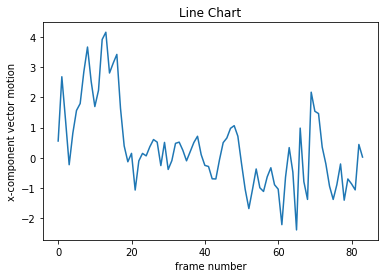

In [16]:
# Open Capture of the source video
cap = cv2.VideoCapture(video_src)

# Constants
## Describes the type of font to be used.
font = cv2.FONT_HERSHEY_SIMPLEX
## Color of text
color =  (0, 255, 255)
## Thresholds for the drawing of the arrow
threshold_left = 3.5
threshold_right = -1.5

# Retrieving of the first and second frame of the video
ret, frame = cap.read()
prev_frame = preprocessing(frame)
ret, frame = cap.read() 
next_frame = preprocessing(frame)
## Get the dimensions of the frames
height = int(next_frame.shape[0])
width = int(next_frame.shape[1])

# Config output video
## mp4
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("videos/lane_change_detection.mp4", fourcc, 30, (width, height), False)

# Creation of mask
offset = 150
height -= offset
trapezoide = np.array([[(0, height/2-offset), 
                        (0,height/2+offset), 
                        (width, height/2+offset), 
                        (width, height/2-offset),]], np.int32)
mask_windshield = np.zeros_like(next_frame)
cv2.fillPoly(mask_windshield, trapezoide, 255)
## Apply mask
prev_frame_masked = cv2.bitwise_and(prev_frame, mask_windshield)
next_frame_masked = cv2.bitwise_and(next_frame, mask_windshield)

# Don't preprocess this frame, because we need to keep the color. 
# Only apply resize
# This creates a 3D image to be able to display the results of the flow
frame_resized = resize_frame(frame)
hsv = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2HSV)
hsv[...,1] = 255

# Variables
avgValueList = []
avgValue = 0
count = 0
delay_left = 0
delay_right = 0

while(ret):
    next_frame = preprocessing(frame)
    next_frame_masked = cv2.bitwise_and(next_frame, mask_windshield)
    
    if count%5 == 0:
        flow = cv2.calcOpticalFlowFarneback(prev_frame_masked, 
                                            next_frame_masked, 
                                            None, 0.5, 5, 20, 5, 7, 1.2, 0)
        x_flow = flow[...,0]
        sumValue = x_flow.sum()
        height, width = x_flow.shape
        avgValue = sumValue / (height * width)
        avgValueList.append(avgValue)
        
        # To display movement frame
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        
        # Only forget the previous frame when performing the movement computation
        prev_frame = next_frame
        prev_frame_masked = next_frame_masked

    if avgValue > threshold_left or (avgValue > threshold_right and delay_left > 0):
        if delay_left == 0:
            delay_left = 20
            delay_right = 0
        else:
            delay_left -= 1
        cv2.arrowedLine(next_frame, (550, 40), (480, 40), ((delay_left%5)*255,0,0), 5)
        
    elif avgValue < threshold_right or (avgValue < threshold_left and delay_right > 0):
        if delay_right == 0:
            delay_right = 20
            delay_left = 0
        else:
            delay_right -= 1
        cv2.arrowedLine(next_frame, (480, 40), (550, 40), ((delay_right%5)*255,0,0), 5)
        
    cv2.putText(next_frame, f"x-component vector motion: {int(avgValue)}", 
                (20, 50), font, 0.8, color , 2, cv2.LINE_4)
    
    #cv2.imshow("Car", next_frame)
    #cv2.imshow("Masked", next_frame_masked)
    #cv2.imshow("Movement", bgr)
    
    # Write the output frame to disk
    writer.write(next_frame)
    
    # creating 'q' as the quit button for the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    ret, frame = cap.read()
    count += 1

writer.release()
cv2.destroyAllWindows()



plt.plot(range(len(avgValueList)),avgValueList)
plt.title('Line Chart')
plt.xlabel('frame number')
plt.ylabel('x-component vector motion')
plt.show()